In [2]:
import sys
import time

# Maths things
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Algorithm
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from metric_learn import MLKR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
data = np.load('regression_data.npy')
target = np.loadtxt('target_values.txt')

In [4]:
error = mean_absolute_error

In [5]:
X_ltrain, X_test, Y_ltrain, Y_test = train_test_split(data, target, test_size = 100, random_state = 7)

In [6]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_ltrain, Y_ltrain, test_size = 100, random_state = 17)

In [7]:
X_train.shape

(554, 27827)

# Feature Selection

## MLKR

### Optimization of the number of PC

In [10]:
%%time
numbers_pc = np.arange(1,30)
losses_mlkr_n_pc = np.zeros((len(numbers_pc)))
for i,n_pc in enumerate(numbers_pc):
    mlkr = MLKR(n_components=n_pc)
    mlkr.fit(X = X_train, y = Y_train)
    T_train = mlkr.transform(X_train)
    T_valid= mlkr.transform(X_valid)
    lr = LinearRegression()
    lr.fit(T_train, Y_train)
    Y_pred = lr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_mlkr_n_pc[i] = loss
    print(n_pc)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Wall time: 1h 18min 56s


In [19]:
optimal_index_n_pc_mlkr = np.unravel_index(losses_mlkr_n_pc.argmin(), losses_mlkr_n_pc.shape)
optimal_n_pc_mlkr = numbers_pc[optimal_index_n_pc_mlkr]
print("Optimal number of n_pc for MLKR using LR is {} ".format(optimal_n_pc_mlkr))

Optimal number of n_pc for MLKR using LR is 26 


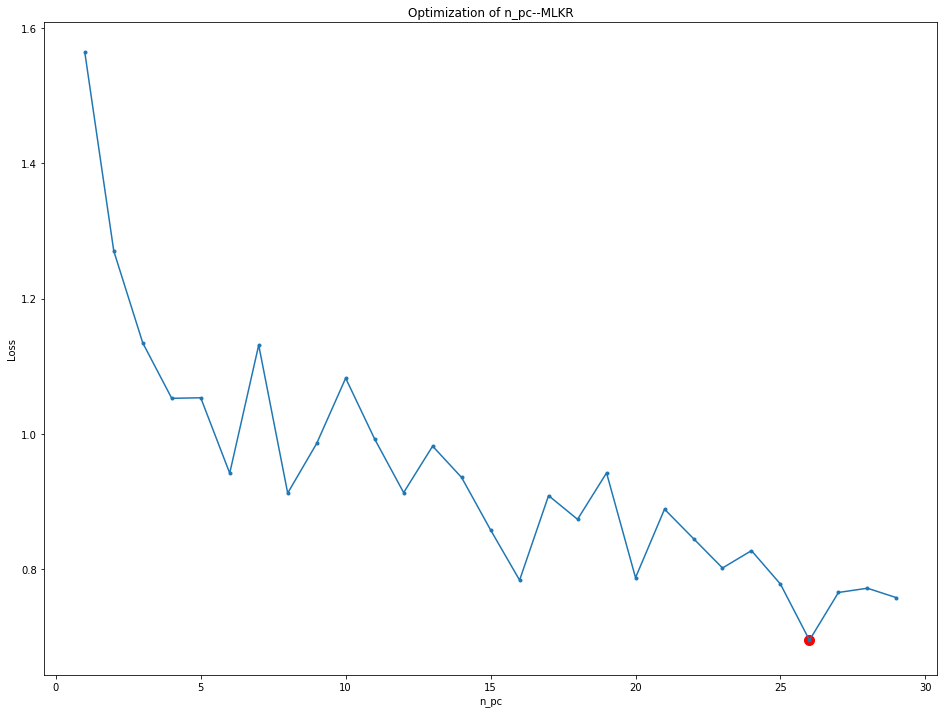

In [86]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_pc,losses_mlkr_n_pc,'.-')
plt.scatter(optimal_n_pc_mlkr, losses_mlkr_n_pc[optimal_index_n_pc_mlkr], s = 100,marker='o', color='r')
plt.xlabel('n_pc')
#plt.yscale('log')
plt.ylabel('Loss')
#plt.legend()
plt.title('Optimization of n_pc--'+'MLKR')
plt.show()

# Retrain and Map

In [98]:
optimal_n_pc_mlkr = 37

In [61]:
best_mlkr = MLKR(n_components=37)
best_mlkr.fit(X = X_ltrain, y = Y_ltrain)
T_ltrain = best_mlkr.transform(X_ltrain)
T_train  = best_mlkr.transform(X_train)
T_valid  = best_mlkr.transform(X_valid)
T_test   = best_mlkr.transform(X_test)

# Try different regression models

## Linear Regression

### No need for optimization

### Learning Curve

In [62]:
lr = LinearRegression()
numbers_train = np.arange(54,655,50)
losses_lr = np.zeros((len(numbers_train)))

In [63]:
%%time
for i,n in enumerate(numbers_train):
    Tt_train = T_ltrain[:n]
    Yt_train = Y_ltrain[:n]
    lr.fit(Tt_train,Yt_train)
    Y_pred = lr.predict(T_test)
    loss = error(Y_test, Y_pred)
    losses_lr[i] = loss
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
Wall time: 35.9 ms


In [116]:
optimal_index_loss_lr = np.unravel_index(losses_lr.argmin(), losses_lr.shape)
optimal_n_train_lr = numbers_train[optimal_index_loss_lr]
min_loss_lr = losses_lr[optimal_index_loss_lr]
print("Minimum loss of LR with MLKR is {} when number of train is {}  ".format(min_loss_lr,optimal_n_train_lr))

Minimum loss of LR with MLKR is 0.7056391345734366 when number of train is 654  


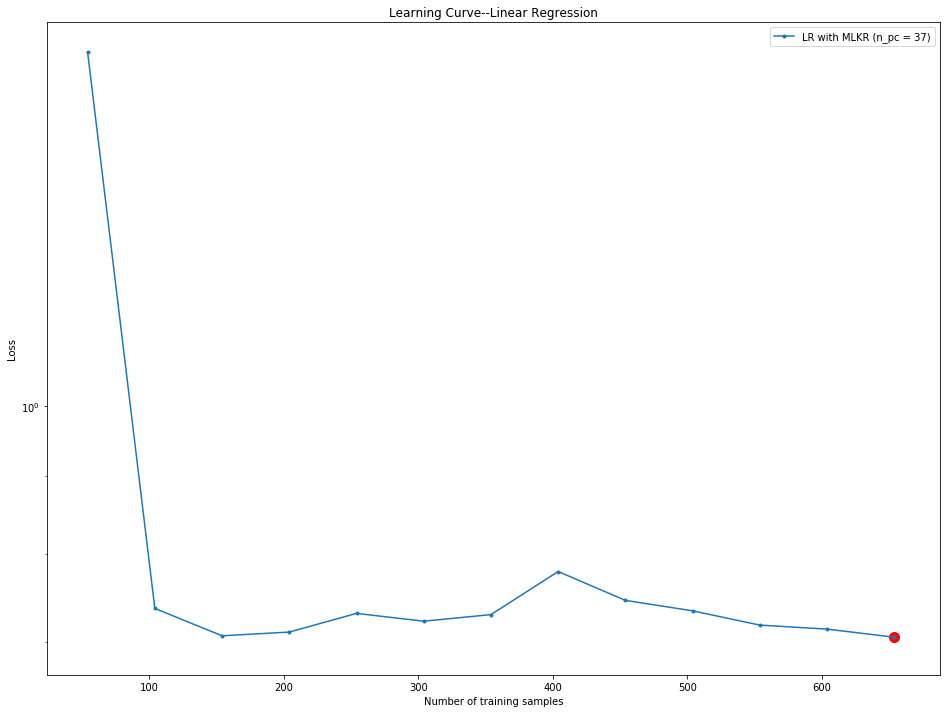

In [99]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_train,losses_lr,'.-', label='LR with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_n_train_lr, min_loss_lr, s = 100,marker='o', color='r')
plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve--'+'Linear Regression')
plt.show()

## Ridge Regression

### Optimization

#### Optimization of alpha

In [91]:
%%time
alphas =  np.logspace(-10, 4, 29)
losses_rr_alpha = np.zeros((len(alphas)))
for i,alpha in enumerate(alphas):
    rr = Ridge(alpha = alpha)
    rr.fit(T_train, Y_train)
    Y_pred = rr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_rr_alpha[i] = loss
    print(alpha)

1e-10
3.1622776601683795e-10
1e-09
3.1622776601683795e-09
1e-08
3.162277660168379e-08
1e-07
3.162277660168379e-07
1e-06
3.162277660168379e-06
1e-05
3.1622776601683795e-05
0.0001
0.00031622776601683794
0.001
0.0031622776601683794
0.01
0.03162277660168379
0.1
0.31622776601683794
1.0
3.1622776601683795
10.0
31.622776601683793
100.0
316.22776601683796
1000.0
3162.2776601683795
10000.0
Wall time: 58.4 ms


In [112]:
optimal_index_alpha_rr = np.unravel_index(losses_rr_alpha.argmin(), losses_rr_alpha.shape)
optimal_alpha_rr = alphas[optimal_index_alpha_rr]
print("Optimal alpha for RR with MLKR is {} ".format(optimal_alpha_rr))

Optimal alpha for RR with MLKR is 0.03162277660168379 


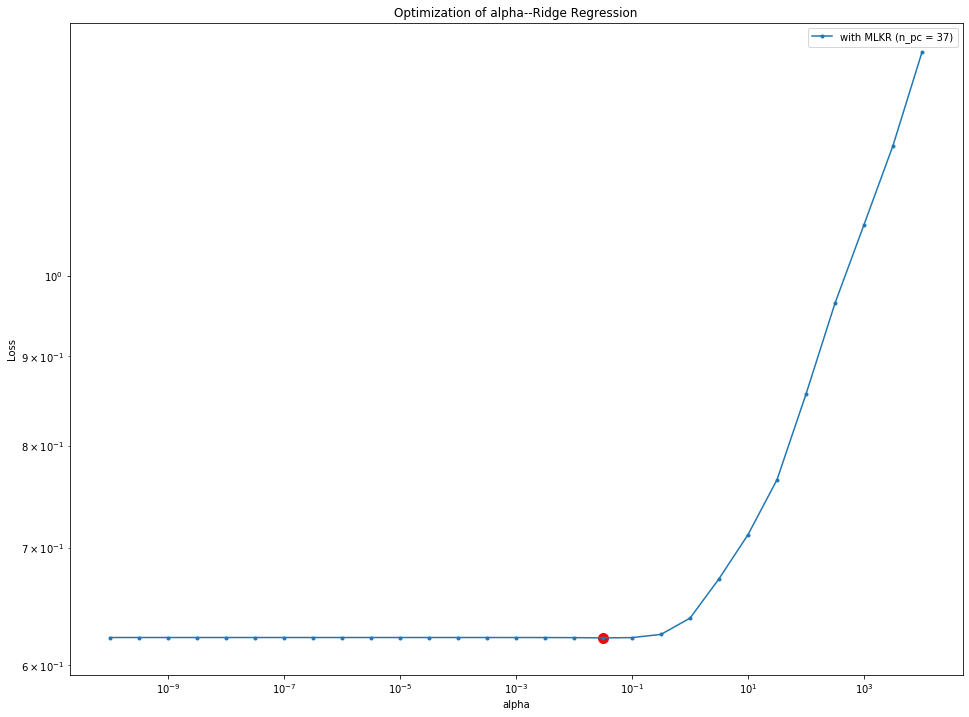

In [101]:
plt.figure(figsize=(16, 12))
plt.plot(alphas,losses_rr_alpha,'.-', label='with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_alpha_rr, losses_rr_alpha[optimal_index_alpha_rr], s = 100,marker='o', color='r')
plt.xlabel('alpha')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Optimization of alpha--'+'Ridge Regression')
plt.show()

### Learning Curve

In [69]:
best_rr = Ridge(alpha = optimal_alpha_rr)
numbers_train = np.arange(54,655,50)
losses_rr = np.zeros((len(numbers_train)))

In [70]:
%%time
for i,n in enumerate(numbers_train):
    Tt_train = T_ltrain[:n]
    Yt_train = Y_ltrain[:n]
    best_rr.fit(Tt_train,Yt_train)
    Y_pred = best_rr.predict(T_test)
    loss = error(Y_test, Y_pred)
    losses_rr[i] = loss
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
Wall time: 26.4 ms


In [71]:
losses_rr

array([1.20450995, 0.70938893, 0.69704513, 0.70462669, 0.72351999,
       0.71692603, 0.72447457, 0.775052  , 0.74394092, 0.7326139 ,
       0.71705075, 0.71317574, 0.70490266])

In [113]:
optimal_index_loss_rr = np.unravel_index(losses_rr.argmin(), losses_rr.shape)
optimal_n_train_rr = numbers_train[optimal_index_loss_rr]
min_loss_rr = losses_rr[optimal_index_loss_rr]
print("Minimum loss of RR with MLKR is {} when number of train is {}  ".format(min_loss_rr,optimal_n_train_rr))

Minimum loss of RR with MLKR is 0.6970451309364087 when number of train is 154  


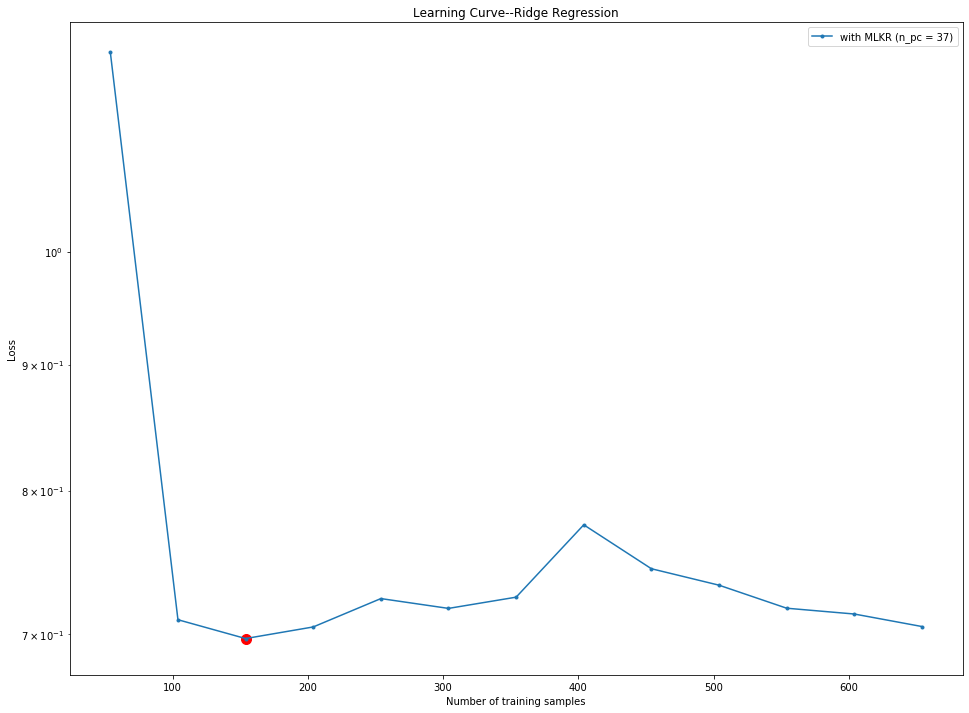

In [102]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_train,losses_rr,'.-', label='with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_n_train_rr, min_loss_rr, s = 100,marker='o', color='r')
plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve--'+'Ridge Regression')
plt.show()

## Kernel Ridge Regression

### Optimization

#### Optimization of gamma

In [74]:
%%time
gammas =  np.logspace(-10, 1, 23)
losses_krr_gamma = np.zeros((len(gammas)))
kernel_params = {"kernel": "rbf", "gamma": 1.0}
for i,gamma in enumerate(gammas):
    kernel_params["gamma"] = gamma
    krr = KernelRidge(alpha = 1e-6, **kernel_params)
    krr.fit(T_train, Y_train)
    Y_pred = krr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_krr_gamma[i] = loss
    print(gamma)

1e-10
3.1622776601683795e-10
1e-09
3.1622776601683795e-09
1e-08
3.162277660168379e-08
1e-07
3.162277660168379e-07
1e-06
3.162277660168379e-06
1e-05
3.1622776601683795e-05
0.0001
0.00031622776601683794
0.001
0.0031622776601683794
0.01
0.03162277660168379
0.1
0.31622776601683794
1.0
3.1622776601683795
10.0
Wall time: 393 ms


In [114]:
optimal_index_gamma_krr = np.unravel_index(losses_krr_gamma.argmin(), losses_krr_gamma.shape)
optimal_gamma_krr = gammas[optimal_index_gamma_krr]
print("Optimal gamma for KRR with MLKR is {} ".format(optimal_gamma_krr))

Optimal gamma for KRR with MLKR is 0.0031622776601683794 


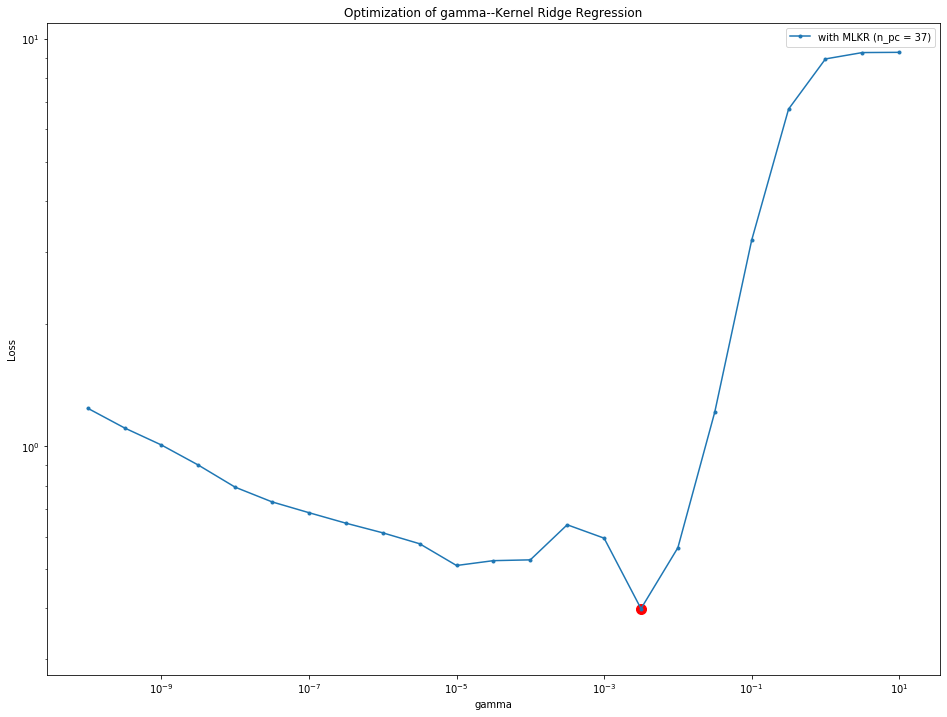

In [103]:
plt.figure(figsize=(16, 12))
plt.plot(gammas,losses_krr_gamma,'.-', label='with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_gamma_krr, losses_krr_gamma[optimal_index_gamma_krr], s = 100,marker='o', color='r')
plt.xlabel('gamma')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Optimization of gamma--'+'Kernel Ridge Regression')
plt.show()

#### Optimization of alpha

In [105]:
%%time
alphas =  np.logspace(-10, 1, 23)
losses_krr_alpha = np.zeros((len(alphas)))
kernel_params = {"kernel": "rbf", "gamma": optimal_gamma_krr}
for i,alpha in enumerate(alphas):
    krr = KernelRidge(alpha = alpha, **kernel_params)
    krr.fit(T_train, Y_train)
    Y_pred = krr.predict(T_valid)
    loss = error(Y_valid, Y_pred)
    losses_krr_alpha[i] = loss
    print(alpha)

1e-10
3.1622776601683795e-10
1e-09
3.1622776601683795e-09
1e-08
3.162277660168379e-08
1e-07
3.162277660168379e-07
1e-06
3.162277660168379e-06
1e-05
3.1622776601683795e-05
0.0001
0.00031622776601683794
0.001
0.0031622776601683794
0.01
0.03162277660168379
0.1
0.31622776601683794
1.0
3.1622776601683795
10.0
Wall time: 412 ms


In [115]:
optimal_index_alpha_krr = np.unravel_index(losses_krr_alpha.argmin(), losses_krr_alpha.shape)
optimal_alpha_krr = alphas[optimal_index_alpha_krr]
print("Optimal alpha for KRR with MLKR is {} ".format(optimal_alpha_krr))

Optimal alpha for KRR with MLKR is 0.0031622776601683794 


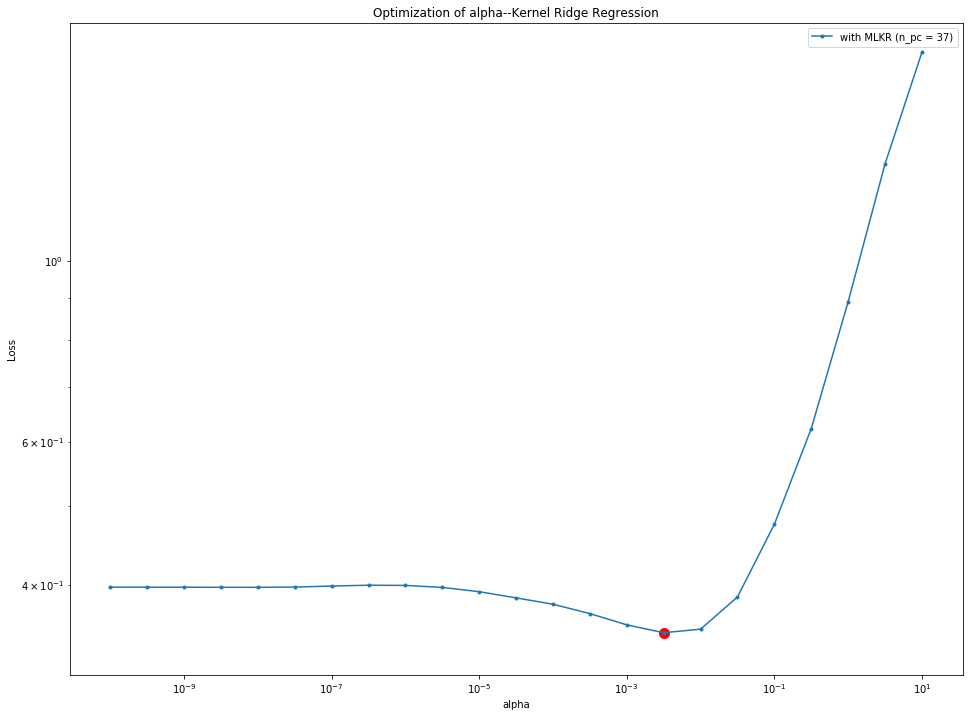

In [107]:
plt.figure(figsize=(16, 12))
plt.plot(alphas,losses_krr_alpha,'.-', label='with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_alpha_krr, losses_krr_alpha[optimal_index_alpha_krr], s = 100,marker='o', color='r')
plt.xlabel('alpha')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Optimization of alpha--'+'Kernel Ridge Regression')
plt.show()

### Learning Curve

In [80]:
best_krr = KernelRidge(alpha = optimal_alpha_krr, **kernel_params)
numbers_train = np.arange(54,655,50)
losses_krr = np.zeros((len(numbers_train)))

In [81]:
%%time
for i,n in enumerate(numbers_train):
    Tt_train = T_ltrain[:n]
    Yt_train = Y_ltrain[:n]
    best_krr.fit(Tt_train,Yt_train)
    Y_pred = best_krr.predict(T_test)
    loss = error(Y_test, Y_pred)
    losses_krr[i] = loss
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
Wall time: 122 ms


In [82]:
losses_krr

array([0.96019872, 0.75192478, 0.69837586, 0.62565602, 0.58309502,
       0.46258407, 0.43009259, 0.36469503, 0.32091675, 0.35454627,
       0.36229869, 0.35220758, 0.33425829])

In [108]:
optimal_index_loss_krr = np.unravel_index(losses_krr.argmin(), losses_krr.shape)
optimal_n_train_krr = numbers_train[optimal_index_loss_krr]
min_loss_krr = losses_krr[optimal_index_loss_krr]
print("Minimum loss of KRR with MLKR is {} when number of train is {}  ".format(min_loss_krr,optimal_n_train_krr))

Minimum loss of KRR with MLKR is 0.3209167504332383 when number of train is 454  


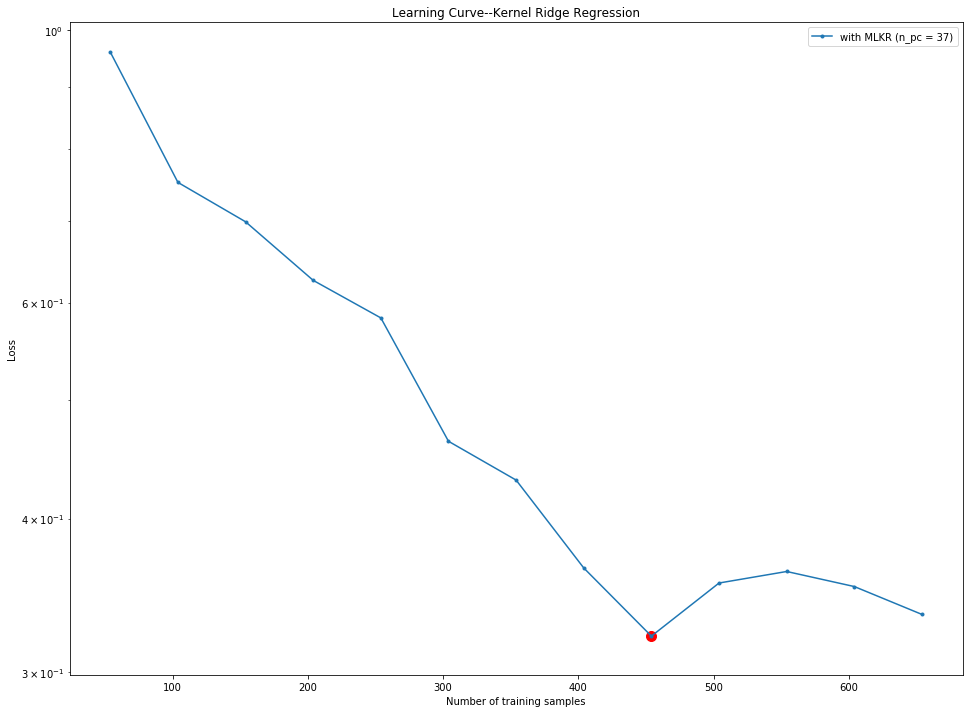

In [110]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_train,losses_krr,'.-', label='with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_n_train_krr, min_loss_krr, s = 100,marker='o', color='r')
plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve--'+'Kernel Ridge Regression')
plt.show()

### Summary

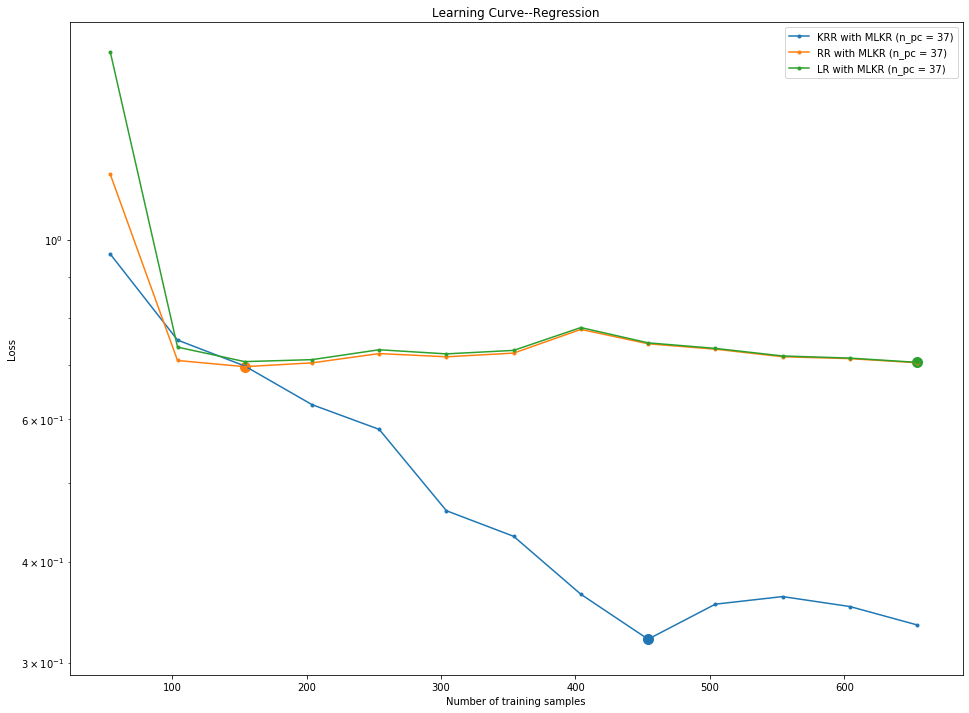

In [111]:
plt.figure(figsize=(16, 12))
plt.plot(numbers_train,losses_krr,'.-', label='KRR with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_n_train_krr, min_loss_krr, s = 100,marker='o')
plt.plot(numbers_train,losses_rr,'.-', label='RR with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_n_train_rr, min_loss_rr, s = 100,marker='o')
plt.plot(numbers_train,losses_lr,'.-', label='LR with MLKR (n_pc = {})'.format(optimal_n_pc_mlkr))
plt.scatter(optimal_n_train_lr, min_loss_lr, s = 100,marker='o')

plt.xlabel('Number of training samples')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve--'+'Regression')
plt.show()